1. Aşama: Model ve Veri Hazırlanıyor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

✅ 'veri seti.xlsx' başarıyla yüklendi.

2. Aşama: Eğitim Başlıyor (5 Run x 100 Epoch)...
Run 1/5 tamamlandı.
Run 2/5 tamamlandı.
Run 3/5 tamamlandı.
Run 4/5 tamamlandı.
Run 5/5 tamamlandı.
🏁 Tüm işlemler tamamlandı. Toplam Süre: 26.42 sn

3. Aşama: Performans Grafikleri Çiziliyor...


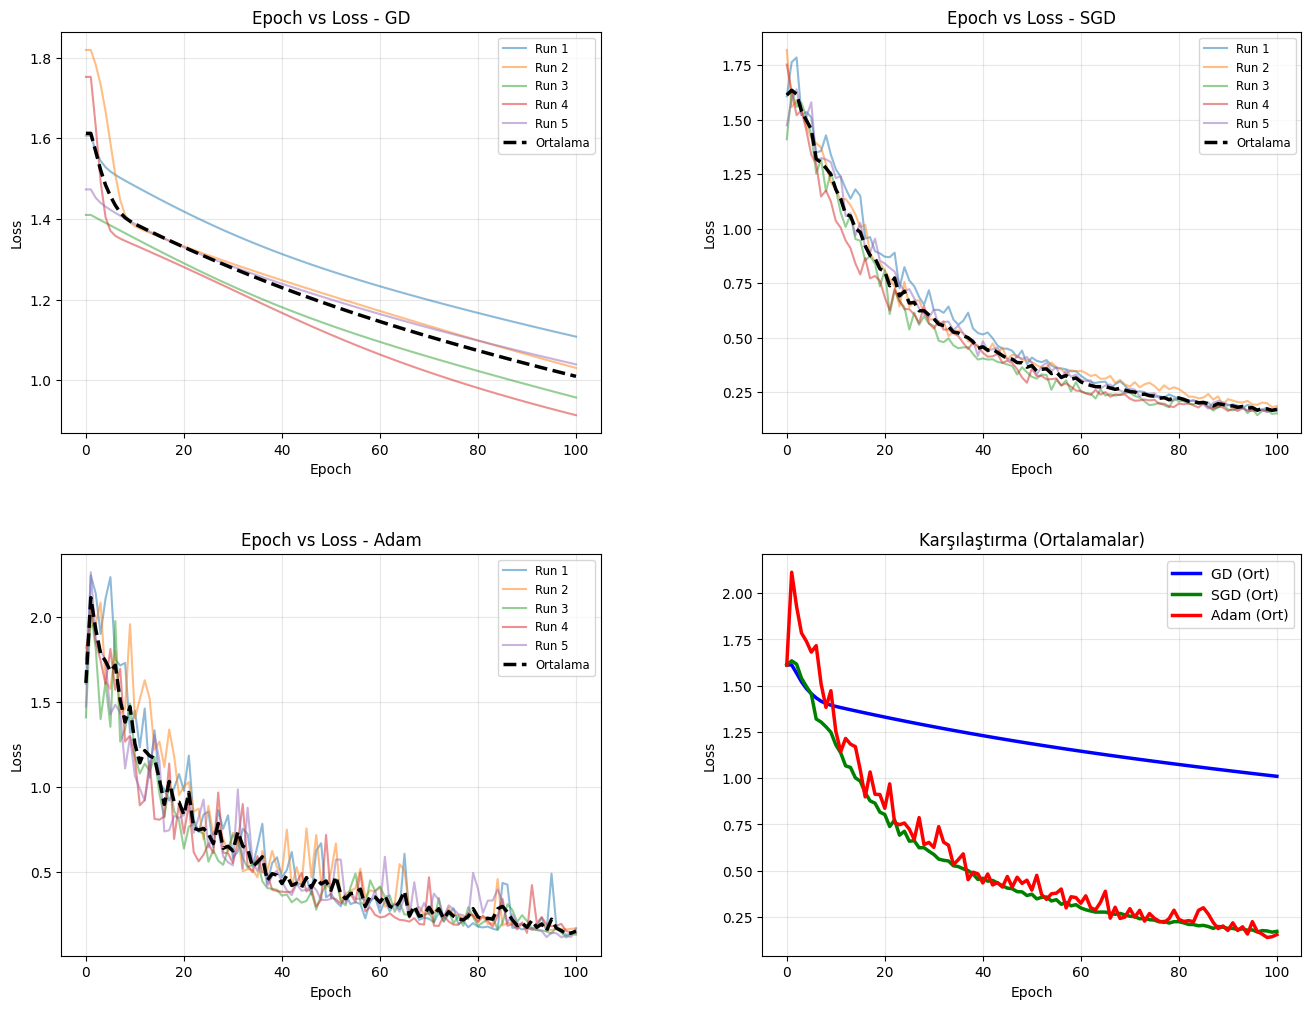

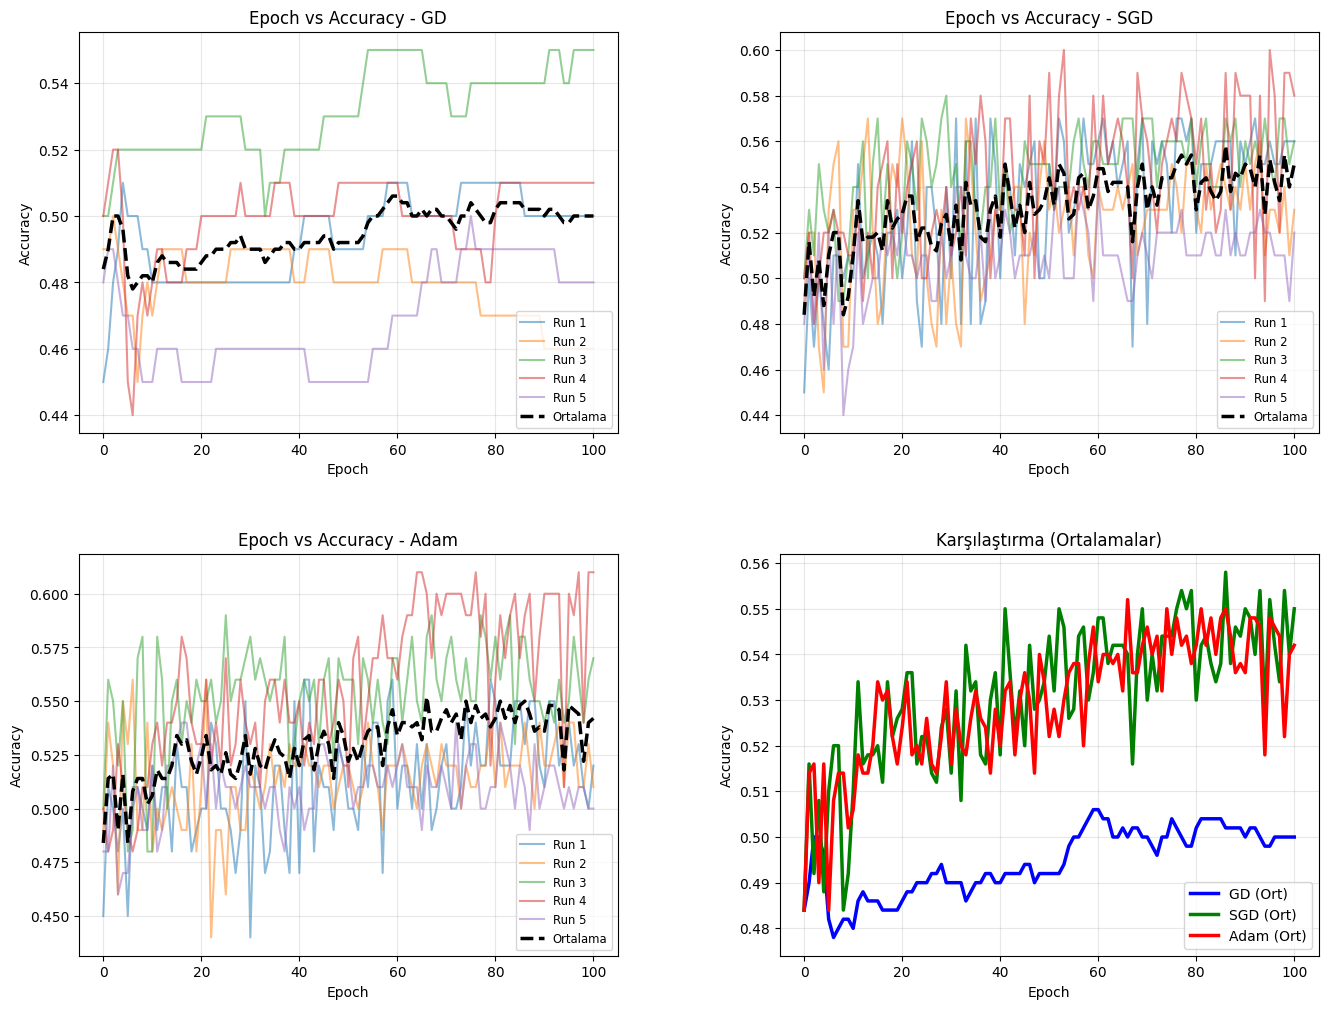

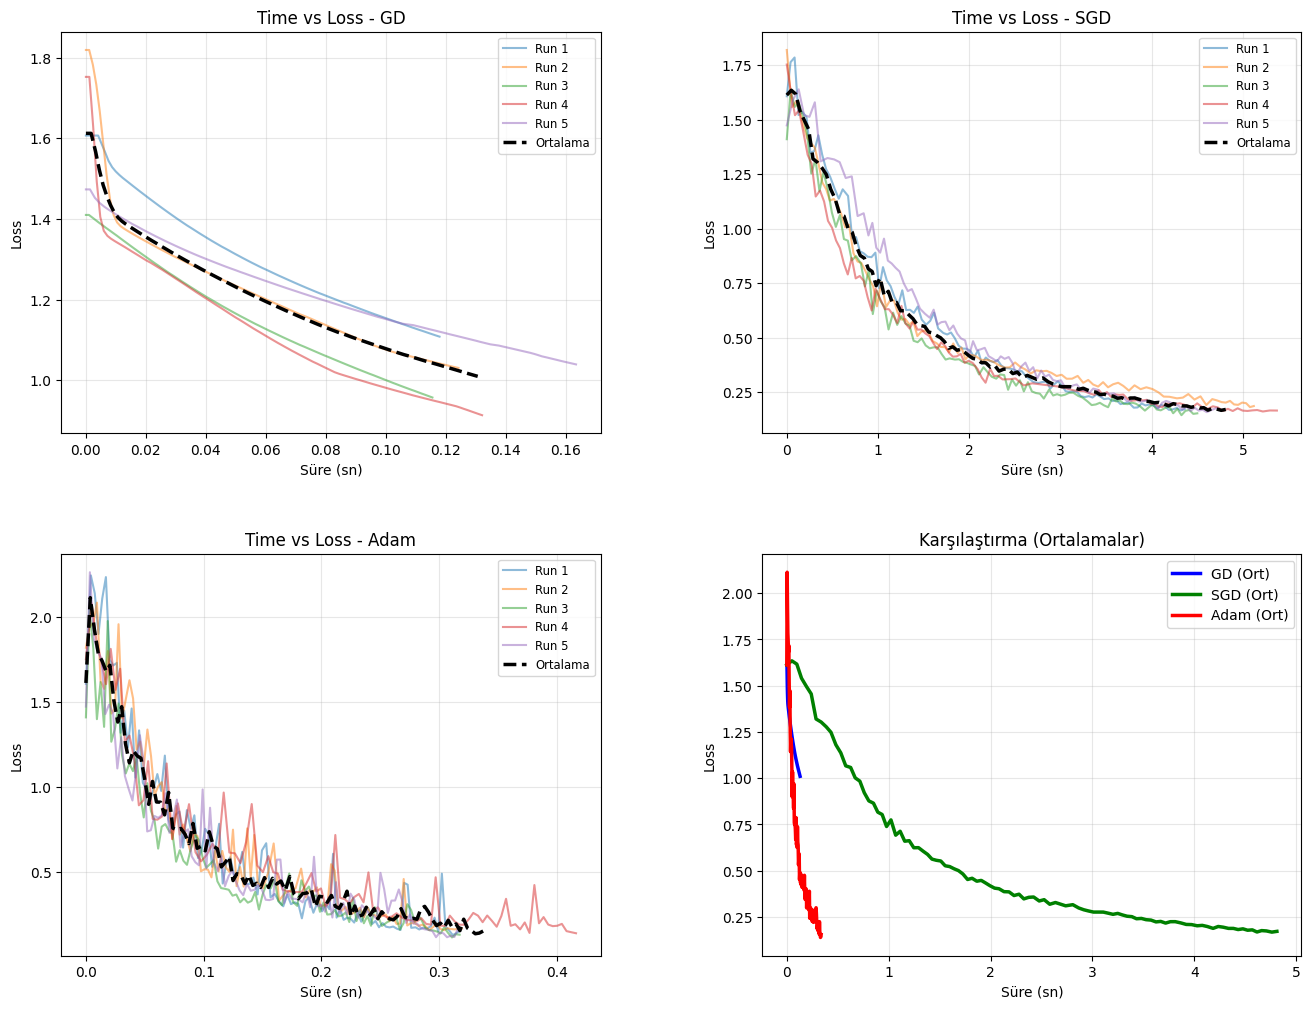

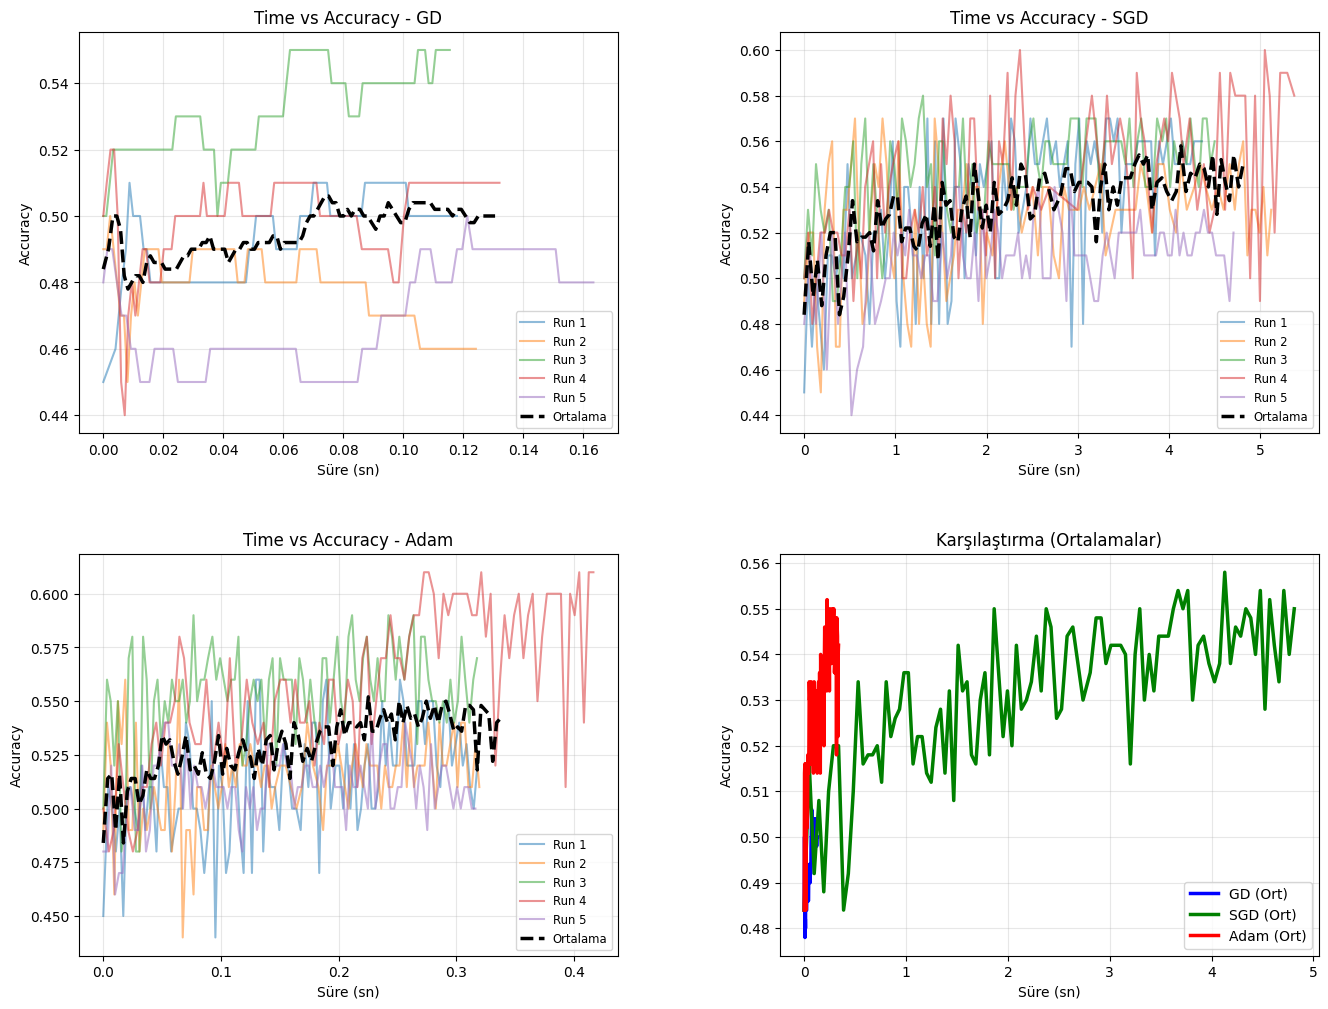


4. Aşama: T-SNE Yörüngeleri Hesaplanıyor...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Grafik çiziliyor...


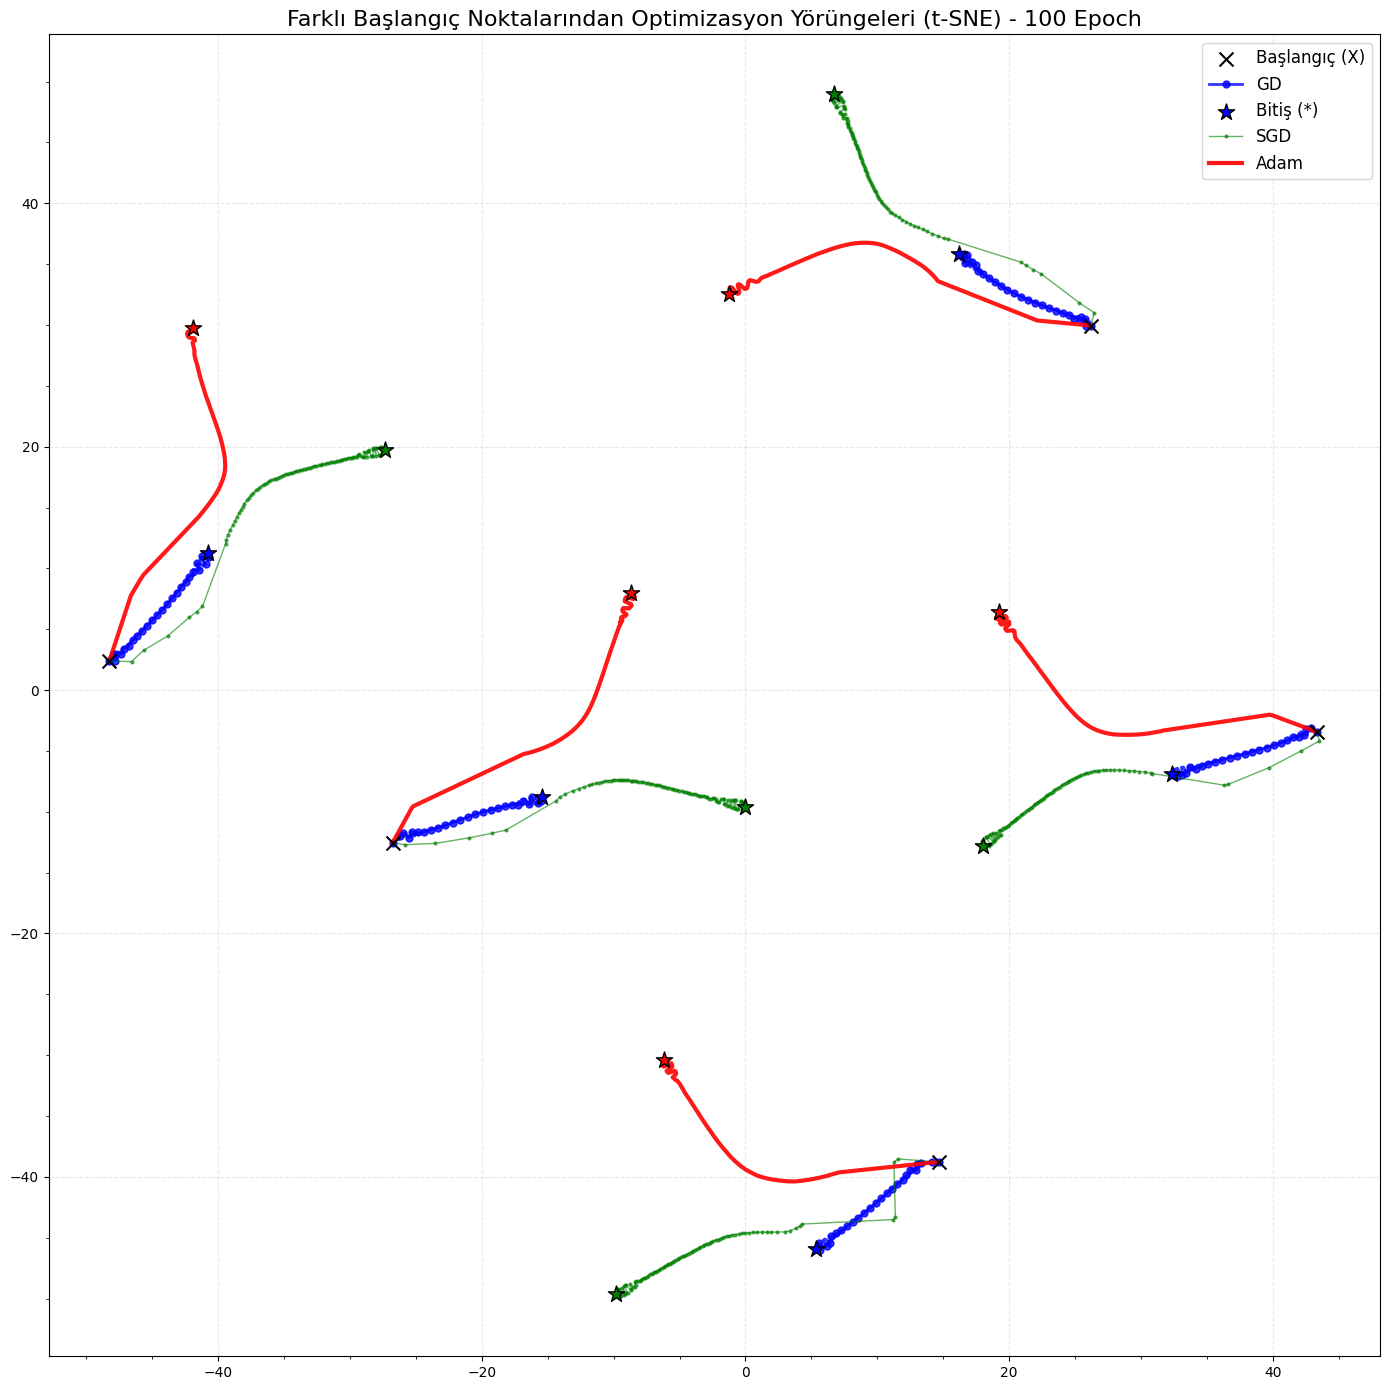

✅ Tüm işlemler başarıyla tamamlandı!


In [ ]:
!pip install -q "transformers==4.41.2" "sentence-transformers==2.7.0" pandas matplotlib torch openpyxl scikit-learn huggingface_hub

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from huggingface_hub import snapshot_download
from sklearn.manifold import TSNE
import time
import sys
# ---------------------------------------------------------
# 1. MODEL YÜKLEME VE VERİ HAZIRLIĞI
# ---------------------------------------------------------

print("1. Aşama: Model ve Veri Hazırlanıyor...")

try:
    model_path = snapshot_download(repo_id="ytu-ce-cosmos/turkish-e5-large",
                                   ignore_patterns=["*.msgpack", "*.h5", "*.ot"],
                                   resume_download=True)
    embedding_model = SentenceTransformer(model_path)
except:
  #soru ve cevapları sayısal vektöre çevirmek için
    print("Model yükleme hatası! Lütfen 'Runtime > Restart Session' yapın.")

# --- VERİ YÜKLEME ---
try:
    df = pd.read_excel("veri seti.xlsx")
    print("✅ 'veri seti.xlsx' başarıyla yüklendi.")
except Exception as e:
    print("\n" + "="*50)
    print("🚨 KRİTİK HATA: 'veri seti.xlsx' DOSYASI BULUNAMADI!")
    print("="*50)
    print(f"Hata Detayı: {e}")
    sys.exit("Dosya eksik olduğu için işlem sonlandırıldı.")
#Etiket sütunun içerisindeki  değerler 1 ve -1 olduğu için sayıya  çevirip sonra hatalı ve boş satırlar temizleniyor.
# Veri Ön İşleme
df.columns = df.columns.str.strip()
if 'Küme' in df.columns: df['Küme'] = df['Küme'].astype(str).str.strip()
df['Etiket'] = pd.to_numeric(df['Etiket'], errors='coerce')
df = df.dropna(subset=['Etiket'])

# Embedding
task = 'Given a Turkish search query, retrieve relevant passages that answer the query'
sorular = [f"Instruct: {task}\nQuery: {q}" for q in df['Soru'].astype(str).tolist()]
cevaplar = df['Cevap'].astype(str).tolist()

soru_vecs = embedding_model.encode(sorular, normalize_embeddings=True)
cevap_vecs = embedding_model.encode(cevaplar, normalize_embeddings=True)

#Soru ve cevap metinlerini modele  verilip vektörlere dönüşüyor. Soru ve cevap vektörlerini concat işlemi yaparak giriş vektörü oluşuyor.

X_final = np.hstack((soru_vecs, cevap_vecs, np.ones((len(soru_vecs), 1)))) # Bias ekliyoruz
y_final = df['Etiket'].values.reshape(-1, 1).astype(np.float32)

#Son sütuna 1 ekleyerek bias’ı  içeriye katıyor. (x_final)


#Excel dosyasında ‘Küme’  sütununda yer alan Eğitim/Test  isimlerine göre veri kümesini eğitim ve test olarak ayırdım.
#Eğitim için ‘Eğitim’ yazan satırlar,  test için ise ‘Test’ yazan satırlar  kullanılmıştır
# Train/Test Split
train_mask = df['Küme'].str.contains('Eğitim', case=False, na=False)
test_mask  = df['Küme'].str.contains('Test',   case=False, na=False)

if train_mask.sum() == 0:
    n = len(df) // 2
    X_train, y_train = torch.tensor(X_final[:n]).float(),  torch.tensor(y_final[:n]).float()
    X_test,  y_test  = torch.tensor(X_final[n:]).float(),  torch.tensor(y_final[n:]).float()
else:
    X_train, y_train = torch.tensor(X_final[train_mask]).float(), torch.tensor(y_final[train_mask]).float()
    X_test,  y_test  = torch.tensor(X_final[test_mask]).float(),  torch.tensor(y_final[test_mask]).float()

# ---------------------------------------------------------
# 2. EĞİTİM DÖNGÜSÜ

#tanh modeli tanımlanıyor
#Çıktının işaretine göre doğruluk hesabı yapılır
class OdevModeli(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, 1, bias=False)
        self.activation = nn.Tanh()
    def forward(self, x):
        return self.activation(self.linear(x))

def accuracy(y_pred, y_true):
    return (torch.sign(y_pred) == y_true).float().mean().item()


## 5 farklı  başlangıç ağırlığı ve 100 epoch ayarlanıyor.
optimizers = ["GD", "SGD", "Adam"]
runs = 5
epochs = 100

full_results = {opt: [] for opt in optimizers}
weight_history = {opt: [] for opt in optimizers}

print(f"\n2. Aşama: Eğitim Başlıyor ({runs} Run x {epochs} Epoch)...")
total_start = time.time()

for r in range(runs):
    initial_w = torch.randn(1, X_train.shape[1])

    for opt_name in optimizers:
        run_start = time.time()
        model = OdevModeli(X_train.shape[1])
        with torch.no_grad(): model.linear.weight.copy_(initial_w)

        # Parametreler


        if opt_name == "GD":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
            batch = len(X_train)
        elif opt_name == "SGD":
            optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            batch = 1
        else: # Adam
            optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
            batch = 32

        criterion = nn.MSELoss()

        #Eğitim döngüsü: her epoch’ta veriyi karıştırıyor, optimizer’a  göre batch batch modeli güncelliyor.


        run_res = {'loss': [], 'acc': [], 'time': []}
        run_weights = []


        with torch.no_grad():
            run_res['acc'].append(accuracy(model(X_test), y_test))
            run_res['loss'].append(criterion(model(X_train), y_train).item())
            run_res['time'].append(0.0)
            run_weights.append(model.linear.weight.data.clone().cpu().numpy().flatten())

        loop_start = time.time()

        for epoch in range(epochs):
            perm = torch.randperm(len(X_train))
            Xs, ys = X_train[perm], y_train[perm]
            safe_batch = batch if batch > 0 else 1
            epoch_loss = 0

            for i in range(0, len(X_train), safe_batch):
                optimizer.zero_grad()
                out = model(Xs[i:i+safe_batch])
                loss = criterion(out, ys[i:i+safe_batch])
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
        #Her adımda gradient hesaplayıp weight güncelliyor
            run_res['loss'].append(epoch_loss / (len(X_train)/safe_batch))
            run_res['time'].append(time.time() - loop_start)
#Her epochun sonunda grafikler  ve tSne için loss, zaman, test accuracy, ağırlık vektörü kaydediliyor
            with torch.no_grad():
                run_res['acc'].append(accuracy(model(X_test), y_test))

            run_weights.append(model.linear.weight.data.clone().cpu().numpy().flatten())

        full_results[opt_name].append(run_res)
        weight_history[opt_name].append(run_weights)

    print(f"Run {r+1}/{runs} tamamlandı.")

print(f"🏁 Tüm işlemler tamamlandı. Toplam Süre: {time.time()-total_start:.2f} sn")

# ---------------------------------------------------------
# 3. GRAFİK ÇİZİMLERİ
# ---------------------------------------------------------
print("\n3. Aşama: Performans Grafikleri Çiziliyor...")

run_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']


#3 tanesi: her optimizer için 5 run  + ortalama 1 tanesi: üç optimizer’ın  ortalama eğrilerinin  karşılaştırması
def plot_spaghetti(metric_key, y_label, x_key='epoch', title_prefix="", use_log=False):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    algo_map = {0: (0,0, 'GD'), 1: (0,1, 'SGD'), 2: (1,0, 'Adam')}

    # KONUM BELİRLEME MANTIĞI
    if metric_key == 'acc':
        legend_loc = 'lower right'
    else:
        legend_loc = 'upper right'

    # 1. Bireysel Grafikler
    for idx, (r, c, name) in algo_map.items():
        ax = axes[r, c]
        runs_data = full_results[name]

        for i, run in enumerate(runs_data):
            y_val = run[metric_key]
            x_val = run['time'] if x_key == 'time' else range(len(y_val))
            ax.plot(x_val, y_val, alpha=0.5, linewidth=1.5, color=run_colors[i], label=f'Run {i+1}')

        min_len = min([len(run[metric_key]) for run in runs_data])
        avg_y = np.mean([run[metric_key][:min_len] for run in runs_data], axis=0)

        if x_key == 'time':
            avg_x = np.mean([run['time'][:min_len] for run in runs_data], axis=0)
        else:
            avg_x = range(min_len)

        ax.plot(avg_x, avg_y, 'k--', linewidth=2.5, label='Ortalama')

        ax.set_title(f"{title_prefix} - {name}")
        ax.set_xlabel('Süre (sn)' if x_key == 'time' else 'Epoch')
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)
        if use_log and x_key == 'time': ax.set_xscale('log')

        # LEGEND KONUMLANDIRMA
        ax.legend(fontsize='small', loc=legend_loc)

    # 2. Karşılaştırma Grafiği
    ax_comp = axes[1, 1]
    comp_colors = {'GD': 'blue', 'SGD': 'green', 'Adam': 'red'}

    for name in optimizers:
        runs_data = full_results[name]
        min_len = min([len(run[metric_key]) for run in runs_data])
        avg_y = np.mean([run[metric_key][:min_len] for run in runs_data], axis=0)
        if x_key == 'time':
            avg_x = np.mean([run['time'][:min_len] for run in runs_data], axis=0)
        else:
            avg_x = range(min_len)
        ax_comp.plot(avg_x, avg_y, label=f"{name} (Ort)", color=comp_colors[name], linewidth=2.5)

    ax_comp.set_title("Karşılaştırma (Ortalamalar)")
    ax_comp.set_xlabel('Süre (sn)' if x_key == 'time' else 'Epoch')
    ax_comp.set_ylabel(y_label)

    # Karşılaştırma grafiği için de aynı konumu kullanalım
    ax_comp.legend(loc=legend_loc)

    ax_comp.grid(True, alpha=0.3)
    if use_log and x_key == 'time': ax_comp.set_xscale('log')

    plt.show()

plot_spaghetti('loss', 'Loss', x_key='epoch', title_prefix="Epoch vs Loss")
plot_spaghetti('acc', 'Accuracy', x_key='epoch', title_prefix="Epoch vs Accuracy")
plot_spaghetti('loss', 'Loss', x_key='time', title_prefix="Time vs Loss", use_log=False)
plot_spaghetti('acc', 'Accuracy', x_key='time', title_prefix="Time vs Accuracy", use_log=False)

# ---------------------------------------------------------
# 4. T-SNE YÖRÜNGELERİ
# ---------------------------------------------------------
print("\n4. Aşama: T-SNE Yörüngeleri Hesaplanıyor...")

all_weights_flat = []
for r in range(runs):
    for opt in optimizers:
        all_weights_flat.extend(weight_history[opt][r])

#Eğitim boyunca kaydedilen  tüm ağırlık vektörleri tek  listede toplanıyo
tsne = TSNE(n_components=2, perplexity=40, n_iter=1500, init='pca', learning_rate='auto', random_state=42)
X_embedded = tsne.fit_transform(np.array(all_weights_flat))

plot_data = {opt: {r: [] for r in range(runs)} for opt in optimizers}
curr_idx = 0
for r in range(runs):
    for opt in optimizers:
        step_count = len(weight_history[opt][r])
        plot_data[opt][r] = X_embedded[curr_idx : curr_idx + step_count]
        curr_idx += step_count

print("Grafik çiziliyor...")
plt.figure(figsize=(14, 14))

styles = {
    'GD': {'color': 'blue', 'lw': 2.0, 'alpha': 0.8, 'marker': 'o', 'ms': 5, 'markevery': 4},
    'SGD': {'color': 'green', 'lw': 1.0, 'alpha': 0.6, 'marker': '.', 'ms': 4, 'markevery': 1},
    'Adam': {'color': 'red', 'lw': 3.0, 'alpha': 0.9, 'marker': None, 'ms': 0, 'markevery': 0}
}

labels_added = []
for r in range(runs):
    start_pt = plot_data['GD'][r][0]
    plt.scatter(start_pt[0], start_pt[1], c='black', marker='x', s=100, zorder=10,
                label='Başlangıç (X)' if r==0 else "")

    for opt in optimizers:
        traj = plot_data[opt][r]
        st = styles[opt]
        lbl = opt if opt not in labels_added else ""
        if lbl: labels_added.append(lbl)

        plt.plot(traj[:, 0], traj[:, 1], color=st['color'], linewidth=st['lw'],
                 alpha=st['alpha'], marker=st['marker'], markersize=st['ms'],
                 markevery=st.get('markevery', None), label=lbl)

        plt.scatter(traj[-1, 0], traj[-1, 1], facecolors=st['color'], edgecolors='black',
                    marker='*', s=150, zorder=10,
                    label='Bitiş (*)' if r==0 and opt=='GD' else "")

plt.title("Farklı Başlangıç Noktalarından Optimizasyon Yörüngeleri (t-SNE) - 100 Epoch", fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.minorticks_on()
plt.tight_layout()
plt.show()
print("✅ Tüm işlemler başarıyla tamamlandı!")